In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

In [2]:
data = pd.read_csv('../data/data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [3]:
def analysis(data: pd.DataFrame):
    # Drop excessive columns
    excessive_columns = ['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1']
    data = data.drop(columns=excessive_columns, errors='ignore')
    
    # Check for nans
    print('Are there any None/NaNs?', data.isnull().values.any(), '\n')
    
    # Take a look at the data
    print(data.describe(), '\n')
    
    # Plot histogram for categorial features
    for column in ['zone_id', 'banner_id', 'os_id', 'country_id', 'campaign_clicks']:
        counts = data[column].value_counts()
        print(counts)
        print(f'Unique: {len(counts.index)}')
        plt.hist(data[column])
        plt.title(column)
        plt.show()
        
    # Convert date to proper format
    data['date_time'] = pd.to_datetime(data['date_time'])
        
    # Check the dates (the last day is our test sample)
    print(data['date_time'].dt.date.value_counts(), '\n')
    
    # Confirm that impressions column is constant
    print('Are all impressions == 1?', (data['impressions'] == 1).all())
    
    return data

Are there any None/NaNs? False 

            zone_id     banner_id  campaign_clicks         os_id  \
count  1.582147e+07  1.582147e+07     1.582147e+07  1.582147e+07   
mean   8.152679e+01  3.816483e+02     6.238540e-01  1.840605e+00   
std    1.632448e+02  3.959386e+02     9.249152e+00  1.530005e+00   
min    0.000000e+00  0.000000e+00     0.000000e+00  0.000000e+00   
25%    1.400000e+01  5.200000e+01     0.000000e+00  1.000000e+00   
50%    1.900000e+01  2.170000e+02     0.000000e+00  2.000000e+00   
75%    6.000000e+01  6.110000e+02     0.000000e+00  3.000000e+00   
max    3.443000e+03  1.632000e+03     8.290000e+02  1.000000e+01   

         country_id  impressions        clicks  
count  1.582147e+07   15821472.0  1.582147e+07  
mean   4.346986e+00          1.0  2.668835e-02  
std    4.317701e+00          0.0  1.611710e-01  
min    0.000000e+00          1.0  0.000000e+00  
25%    0.000000e+00          1.0  0.000000e+00  
50%    4.000000e+00          1.0  0.000000e+00  
75%    7.00

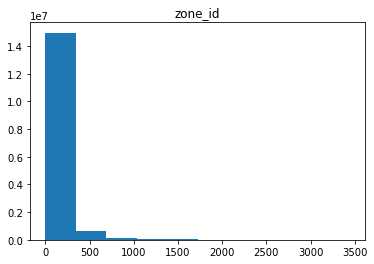

22      613367
361     387563
3       286999
18      262946
21      246378
         ...  
1501         1
1503         1
1504         1
1507         1
1632         1
Name: banner_id, Length: 1633, dtype: int64
Unique: 1633


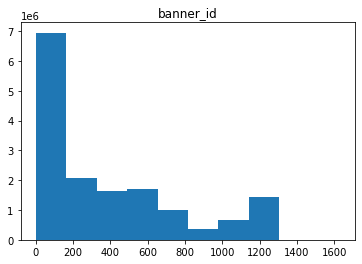

2     4589979
0     3856798
1     3178693
4     3012541
3      759767
6      310346
5      111946
8        1273
7          99
9          25
10          5
Name: os_id, dtype: int64
Unique: 11


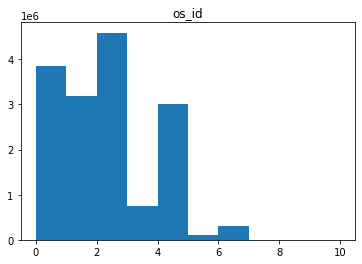

0     4956393
5     1910054
6     1582705
7     1525569
1     1346321
3     1337392
15     603301
12     478038
9      439004
4      388801
10     356490
11     212245
8      210211
13     190855
14     138385
16      79166
2       66542
Name: country_id, dtype: int64
Unique: 17


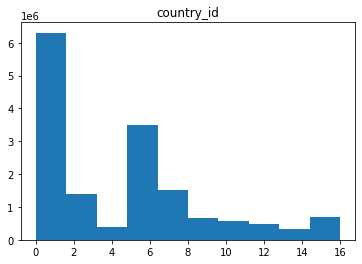

0      13682452
1       1236822
2        342937
3        173528
4        100293
         ...   
802           1
803           1
804           1
807           1
829           1
Name: campaign_clicks, Length: 822, dtype: int64
Unique: 822


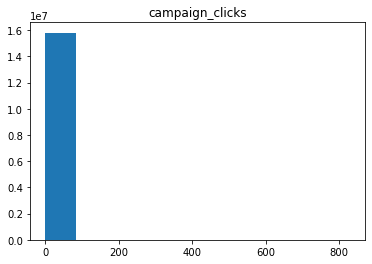

2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date_time, dtype: int64 

Are all impressions == 1? True


In [4]:
data = analysis(data)

In [5]:
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1,1


* Удалили ненужные по условию фичи.
* `None`/`NaN` нет.
* Категориальные фичи кодируем с `OneHotEncoding`.
* Числовую фичу `campaign_clicks` нормируем.
* `2021-09-01` выбивается из остальных дат, выкинем как выброс.
* Все `impressions` равны 1 (что наверное логично, раз данные = показы рекламы), выкинем эту фичу.
* `2021-10-02` последний день. На остальном обучаем, на нём предиктим.
* Вообще дни (дни недели) нам ничего не дадут, так как всего один день в тестовой выборке. Но может разбить на часы, это явно может иметь отношение к клику на определенные сайты.

In [6]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # Drop constant column
    data = data.drop(columns='impressions', errors='ignore')    

    # Remove the outlier day
    data = data[data['date_time'] != '2021-09-01']
    
    # Remove the ys and the numerical feature
    clicks, campaign_clicks = data['clicks'], data[['campaign_clicks']]
    data = data.drop(columns=['clicks', 'campaign_clicks'])
    
    # Scale campaign_clicks
    campaign_clicks = StandardScaler().fit_transform(campaign_clicks)
    
    # Create the hour feature
    data['hour'] = data['date_time'].dt.hour
    
    # Train-test split
    train = data['date_time'] < '2021-10-02'
    X_train, X_test = data[train], data[~train]
    y_train, y_test = clicks[train], clicks[~train]
    
    # Remove excessive date_time feature
    X_train, X_test = X_train.drop(columns=['date_time']).to_numpy(), X_test.drop(columns=['date_time']).to_numpy()
    
    # Use One-Hot Encoding for categorial features
    encoder = OneHotEncoder(handle_unknown='ignore')
    X_train = encoder.fit_transform(X_train)
    X_test = encoder.transform(X_test)

    # Merge with the numerical campaign_clicks
    X_train = sparse.hstack([X_train, campaign_clicks[train]])
    X_test = sparse.hstack([X_test, campaign_clicks[~train]])

    return X_train.tocsr(), y_train, X_test.tocsr(), y_test

In [7]:
X_train, y_train, X_test, y_test = feature_engineering(data)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13692494, 4969), (13692494,), (2128978, 4969), (2128978,))

In [8]:
# Logistic Regression with liblinear (non SGD-like) solver and L2-regularization.
def create_model(C):
    return LogisticRegression(solver='liblinear', random_state=239, C=C, penalty='l2')

In [9]:
# Cross-validation with different Cs
def cv():
    Cs = [0.001, 0.01, 0.1, 1]
    for C in Cs:
        model = create_model(C)
        scores = cross_validate(model, X_train, y_train, scoring=['neg_log_loss', 'roc_auc'])
        neg_log_loss = scores['test_neg_log_loss']
        roc_auc = scores['test_roc_auc']
        print(f'C = {C}')
        print(f'neg_log_loss = {np.mean(neg_log_loss)}')
        print(f'roc_auc = {np.mean(roc_auc)}')

In [ ]:
cv()

C = 0.001
neg_los_loss = -0.11705228371093716
roc_auc = 0.6257158890852914


C = 0.01
neg_los_loss = -0.11887762592801836
roc_auc = 0.6343324285793297


C = 0.1
neg_los_loss = -0.12029670028039849
roc_auc = 0.638174963618054


C = 1
neg_los_loss = -0.12070354528389982
roc_auc = 0.6401710975511747


In [14]:
# According to log loss, best C seems to be 0.001
model = create_model(0.001).fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
my_roc_auc = roc_auc_score(y_test, y_pred_proba)
my_log_loss = log_loss(y_test, y_pred_proba)
print(f'my roc_auc = {my_roc_auc}')
print(f'my log_loss = {my_log_loss}')

my roc_auc = 0.7703144780675439
my log_loss = 0.13566827866435563


In [17]:
y_pred_baseline = np.full(y_pred_proba.shape, np.mean(y_train))
roc_auc_baseline = roc_auc_score(y_test, y_pred_baseline)
log_loss_baseline = log_loss(y_test, y_pred_baseline)
print(f'baseline roc_auc = {roc_auc_baseline}')
print(f'baseline log_loss = {log_loss_baseline}')

baseline roc_auc = 0.5
baseline log_loss = 0.15486198009919555


Обыграли `baseline`.